In [1]:
from __future__ import print_function, division
import os
import torch
import random

import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from math import *
import imutils


from tqdm.notebook import tqdm

#for test model
import time
import datetime

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode
plt.rcParams["figure.figsize"] = (21, 24)

In [2]:
# Function for setting the seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        
#Set seed
set_seed(42)

In [3]:
#GPU check and setup
if torch.cuda.is_available():
    torch.backends.cudnn.determinstic = True
    torch.backends.cudnn.benchmark = False
    
#Check for cuda GPU to run on:
gpu_avail = torch.cuda.is_available()
print(f"Is the GPU available? {gpu_avail}")
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
if gpu_avail:
    print("Device name: " + torch.cuda.get_device_name(0))

Is the GPU available? True
Device: cuda
Device name: NVIDIA GeForce GTX 1080 Ti


In [4]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image, cmap="gray")
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

In [5]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0]+".tiff")
        image = io.imread(img_name)
        image = np.expand_dims(image, axis =2) #add channel dim
        image = image.astype('float')
        
        if (pd.isnull(self.landmarks_frame.iloc[idx, 88])): #figure out if front or profile landmarks
            landmarks = self.landmarks_frame.iloc[idx, 1:87]
        else:
            landmarks = self.landmarks_frame.iloc[idx, 1:147]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [6]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}
    
    
# class Rotate(object):
    
#     def __init__(self, angle):
#         assert isinstance(angle, (int, tuple))
#         self.angle = angle

#     def __call__(self, sample):
#         image, landmarks = sample['image'], sample['landmarks']
#         angle = random.uniform(-self.angle, +self.angle)
        
#         transformation_matrix = torch.tensor([
#             [+cos(radians(angle)), -sin(radians(angle))], 
#             [+sin(radians(angle)), +cos(radians(angle))]
#         ])

#         image = imutils.rotate(np.array(image), angle)

#         landmarks = landmarks - 0.5
#         landmarks = np.matmul(landmarks, transformation_matrix)
#         landmarks = landmarks + 0.5

#         return {'image': image, 'landmarks': landmarks}

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

In [7]:
class Transforms():
    def __init__(self):
        pass
    
    def rotate(self, sample, angle):
        angle = random.uniform(-angle, +angle)
        image, landmarks = sample['image'], sample['landmarks']
        transformation_matrix = torch.tensor([
            [+cos(radians(angle)), -sin(radians(angle))], 
            [+sin(radians(angle)), +cos(radians(angle))]
        ])

        image = imutils.rotate(np.array(image), angle)

        landmarks = landmarks - 0.5
        new_landmarks = np.matmul(landmarks, transformation_matrix)
        new_landmarks = new_landmarks + 0.5
        return {'image': Image.fromarray(image), 'landmarks': new_landmarks}

    def resize(self, sample, img_size):
        image, landmarks = sample['image'], sample['landmarks']
        image = TF.resize(image, img_size)
        return {'image': image, 'landmarks': landmarks}

    def color_jitter(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        color_jitter = transforms.ColorJitter(brightness=0.3, 
                                              contrast=0.3,
                                              saturation=0.3, 
                                              hue=0.1)
        image = color_jitter(image)
        return {'image': image, 'landmarks': landmarks}

    def crop_face(self, sample, crops):
        image, landmarks = sample['image'], sample['landmarks']
        left = int(crops['left'])
        top = int(crops['top'])
        width = int(crops['width'])
        height = int(crops['height'])

        image = TF.crop(image, top, left, height, width)

        img_shape = np.array(image).shape
        landmarks = torch.tensor(landmarks) - torch.tensor([[left, top]])
        landmarks = landmarks / torch.tensor([img_shape[1], img_shape[0]])
        return {'image': image, 'landmarks': landmarks}

    def __call__(self, sample, crops):
        image, landmarks = sample['image'], sample['landmarks']
        image = Image.fromarray(image)
        image, landmarks = self.crop_face(image, landmarks, crops)
        image, landmarks = self.resize(image, landmarks, (224, 224))
        image, landmarks = self.color_jitter(image, landmarks)
        image, landmarks = self.rotate(image, landmarks, angle=10)
        
        image = TF.to_tensor(image)
        image = TF.normalize(image, [0.5], [0.5])
        return {'image': image, 'landmarks': landmarks}

0 (185, 250, 1) (73, 2)


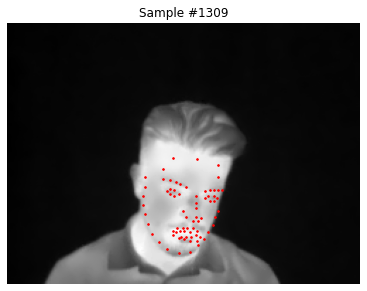

1 (350, 465, 1) (73, 2)


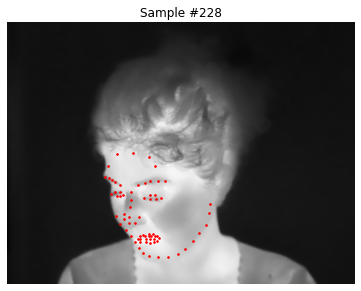

2 (70, 80, 1) (73, 2)


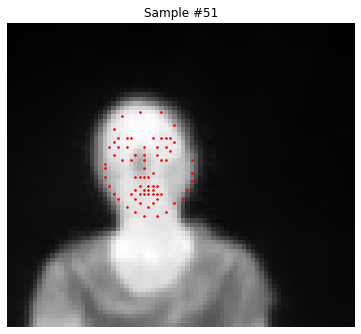

3 (225, 300, 1) (73, 2)


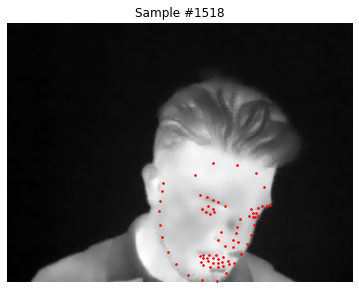

In [8]:
face_dataset = FaceLandmarksDataset(csv_file='.\\Master_front.csv',
                                    root_dir='.\\Master')

fig = plt.figure()

for i in range(len(face_dataset)):
    idx = random.randint(0, len(face_dataset))
    sample = face_dataset[idx]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(idx))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

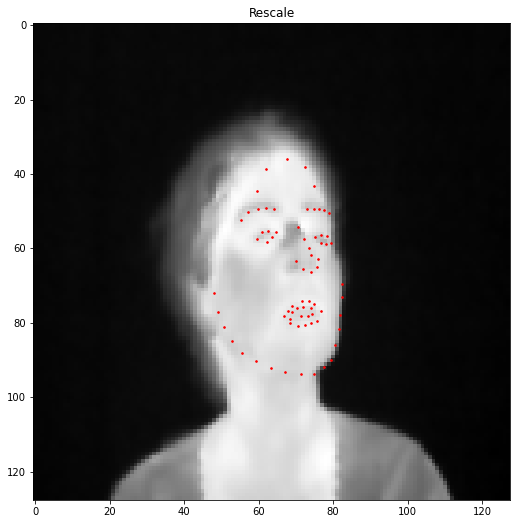

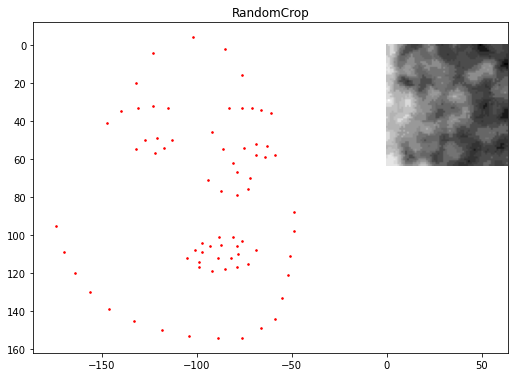

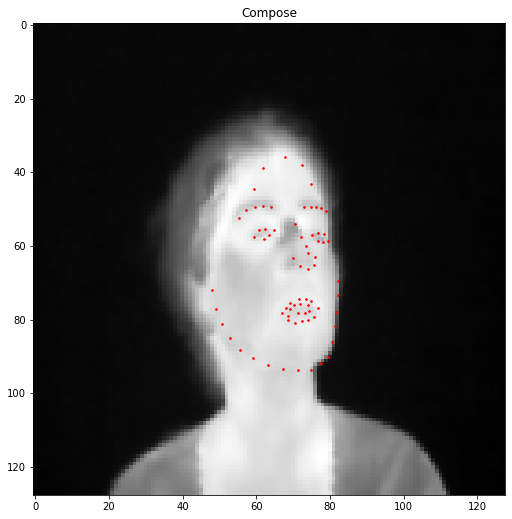

In [9]:
scale = Rescale(128)
crop = RandomCrop(64)
composed = transforms.Compose([Rescale(128)
                              ])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[random.randint(0, len(face_dataset))]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

In [10]:
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)), cmap="gray")

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    landmarks_batch[i, :, 1].numpy() + grid_border_size,
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

In [11]:
# numnan =0
# for i in range(len(dataloader)):
#     sample_batched = next(iter(dataloader))
#     print( sample_batched['image'].size(),
#                   sample_batched['landmarks'].size())
#     images = sample_batched['image'].to(device=device, dtype=torch.float)
#     landmarks = sample_batched['landmarks'].to(device=device, dtype=torch.float)
#     print(torch.isnan(images).any())
#     print(torch.isnan(landmarks).any())
#     if torch.isnan(images).any() or torch.isnan(landmarks).any():
#         numnan +=1
# print(numnan)

In [12]:
train_transform = transforms.Compose([Rescale(128),
                                     RandomCrop(64),
                                     ToTensor()])
valid_transform = transforms.Compose([Rescale(128),
                                      RandomCrop(64),
                                     ToTensor()])

train_dataset = FaceLandmarksDataset(csv_file='.\\Master_profile.csv',
                                           root_dir='.\\Master',
                                           transform = train_transform)
valid_dataset = FaceLandmarksDataset(csv_file='.\\Master_profile.csv',
                                           root_dir='.\\Master',
                                           transform = valid_transform)


len_valid_set = int(0.2*len(train_dataset))
len_train_set = len(train_dataset) - len_valid_set

print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_set))


set_seed(42)                                    
train_set , _  = torch.utils.data.random_split(train_dataset , [len_train_set, len_valid_set])
set_seed(42)
_ , valid_set  = torch.utils.data.random_split(valid_dataset , [len_train_set, len_valid_set])


# shuffle and batch the datasets
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, drop_last=True, pin_memory=True, num_workers=0)
valid_loader = DataLoader(valid_set, batch_size=64, shuffle=True, num_workers=0)


The length of Train set is 1080
The length of Valid set is 270


In [13]:
# numnan =0
# for i in range(len(train_loader)):
#     sample_batched = next(iter(train_loader))
#     print( sample_batched['image'].size(),
#                   sample_batched['landmarks'].size())
#     images = sample_batched['image'].to(device=device, dtype=torch.float)
#     landmarks = sample_batched['landmarks'].to(device=device, dtype=torch.float)
#     print(torch.isnan(images).any())
#     print(torch.isnan(landmarks).any())
#     if torch.isnan(images).any() or torch.isnan(landmarks).any():
#         numnan +=1
# print(numnan)

In [14]:
# numnan =0
# for i in range(len(valid_loader)):
#     sample_batched = next(iter(valid_loader))
#     print( sample_batched['image'].size(),
#                   sample_batched['landmarks'].size())
#     images = sample_batched['image'].to(device=device, dtype=torch.float)
#     landmarks = sample_batched['landmarks'].to(device=device, dtype=torch.float)
#     print(torch.isnan(images).any())
#     print(torch.isnan(landmarks).any())
#     if torch.isnan(images).any() or torch.isnan(landmarks).any():
#         numnan +=1
# print(numnan)

In [15]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.utils.checkpoint as cp
# from collections import OrderedDict
# from torch import Tensor
# from torch.jit.annotations import List

# class _DenseLayer(nn.Module):
#     def __init__(self, num_input_features, growth_rate, bn_size, drop_rate, memory_efficient=False):
#         super(_DenseLayer, self).__init__()
#         self.add_module('norm1', nn.BatchNorm2d(num_input_features)),
#         self.add_module('relu1', nn.ReLU(inplace=True)),
#         self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
#                                            growth_rate, kernel_size=1, stride=1,
#                                            bias=False)),
#         self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate)),
#         self.add_module('relu2', nn.ReLU(inplace=True)),
#         self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
#                                            kernel_size=3, stride=1, padding=1,
#                                            bias=False)),
#         self.drop_rate = float(drop_rate)
#         self.memory_efficient = memory_efficient

#     def bn_function(self, inputs):
#         # type: (List[Tensor]) -> Tensor
#         concated_features = torch.cat(inputs, 1)
#         bottleneck_output = self.conv1(self.relu1(self.norm1(concated_features)))  # noqa: T484
#         return bottleneck_output

#     # todo: rewrite when torchscript supports any
#     def any_requires_grad(self, input):
#         # type: (List[Tensor]) -> bool
#         for tensor in input:
#             if tensor.requires_grad:
#                 return True
#         return False

#     @torch.jit.unused  # noqa: T484
#     def call_checkpoint_bottleneck(self, input):
#         # type: (List[Tensor]) -> Tensor
#         def closure(*inputs):
#             return self.bn_function(inputs)

#         return cp.checkpoint(closure, *input)

#     @torch.jit._overload_method  # noqa: F811
#     def forward(self, input):
#         # type: (List[Tensor]) -> (Tensor)
#         pass

#     @torch.jit._overload_method  # noqa: F811
#     def forward(self, input):
#         # type: (Tensor) -> (Tensor)
#         pass

#     # torchscript does not yet support *args, so we overload method
#     # allowing it to take either a List[Tensor] or single Tensor
#     def forward(self, input):  # noqa: F811
#         if isinstance(input, Tensor):
#             prev_features = [input]
#         else:
#             prev_features = input

#         if self.memory_efficient and self.any_requires_grad(prev_features):
#             if torch.jit.is_scripting():
#                 raise Exception("Memory Efficient not supported in JIT")

#             bottleneck_output = self.call_checkpoint_bottleneck(prev_features)
#         else:
#             bottleneck_output = self.bn_function(prev_features)

#         new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
#         if self.drop_rate > 0:
#             new_features = F.dropout(new_features, p=self.drop_rate,
#                                      training=self.training)
#         return new_features


# class _DenseBlock(nn.ModuleDict):
#     _version = 2

#     def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate, memory_efficient=False):
#         super(_DenseBlock, self).__init__()
#         for i in range(num_layers):
#             layer = _DenseLayer(
#                 num_input_features + i * growth_rate,
#                 growth_rate=growth_rate,
#                 bn_size=bn_size,
#                 drop_rate=drop_rate,
#                 memory_efficient=memory_efficient,
#             )
#             self.add_module('denselayer%d' % (i + 1), layer)

#     def forward(self, init_features):
#         features = [init_features]
#         for name, layer in self.items():
#             new_features = layer(features)
#             features.append(new_features)
#         return torch.cat(features, 1)


# class _Transition(nn.Sequential):
#     def __init__(self, num_input_features, num_output_features):
#         super(_Transition, self).__init__()
#         self.add_module('norm', nn.BatchNorm2d(num_input_features))
#         self.add_module('relu', nn.ReLU(inplace=True))
#         self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
#                                           kernel_size=1, stride=1, bias=False))
#         self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))

# class DenseNet(nn.Module):
#     r"""Densenet-BC model class, based on
#     `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_

#     Args:
#         growth_rate (int) - how many filters to add each layer (`k` in paper)
#         block_config (list of 4 ints) - how many layers in each pooling block
#         num_init_features (int) - the number of filters to learn in the first convolution layer
#         bn_size (int) - multiplicative factor for number of bottle neck layers
#           (i.e. bn_size * k features in the bottleneck layer)
#         drop_rate (float) - dropout rate after each dense layer
#         num_classes (int) - number of classification classes
#         memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
#           but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_
#     """

#     def __init__(self, growth_rate=32, block_config=(12, 24, 48, 32),
#                  num_init_features=64, bn_size=4, drop_rate=0.2, num_classes=146, memory_efficient=False):

#         super(DenseNet, self).__init__()

#         # First convolution
#         self.features = nn.Sequential(OrderedDict([
#             ('conv0', nn.Conv2d(1, num_init_features, kernel_size=7, stride=2,
#                                 padding=3, bias=False)),
#             ('norm0', nn.BatchNorm2d(num_init_features)),
#             ('relu0', nn.ReLU(inplace=True)),
#             ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
#         ]))

#         # Each denseblock
#         num_features = num_init_features
#         for i, num_layers in enumerate(block_config):
#             block = _DenseBlock(
#                 num_layers=num_layers,
#                 num_input_features=num_features,
#                 bn_size=bn_size,
#                 growth_rate=growth_rate,
#                 drop_rate=drop_rate,
#                 memory_efficient=memory_efficient
#             )
#             self.features.add_module('denseblock%d' % (i + 1), block)
#             num_features = num_features + num_layers * growth_rate
#             if i != len(block_config) - 1:
#                 trans = _Transition(num_input_features=num_features,
#                                     num_output_features=num_features // 2)
#                 self.features.add_module('transition%d' % (i + 1), trans)
#                 num_features = num_features // 2

#         # Final batch norm
#         self.features.add_module('norm5', nn.BatchNorm2d(num_features))

#         # Linear layer
#         self.classifier = nn.Linear(num_features, num_classes)

#         # Official init from torch repo.
#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 nn.init.kaiming_normal_(m.weight)
#             elif isinstance(m, nn.BatchNorm2d):
#                 nn.init.constant_(m.weight, 1)
#                 nn.init.constant_(m.bias, 0)
#             elif isinstance(m, nn.Linear):
#                 nn.init.constant_(m.bias, 0)

#     def forward(self, x):
#         features = self.features(x)
#         out = F.relu(features, inplace=True)
#         out = F.adaptive_avg_pool2d(out, (1, 1))
#         out = torch.flatten(out, 1)
#         out = self.classifier(out)
#         return out

In [16]:
from torch.nn import Linear, Conv2d, BatchNorm1d, BatchNorm2d, PReLU, ReLU, Sigmoid, Dropout2d, Dropout, AvgPool2d, MaxPool2d, AdaptiveAvgPool2d, Sequential, Module, Parameter
import torch.nn.functional as F
import torch
import torch.nn as nn
from collections import namedtuple
import math
import pdb

##################################  Original Arcface Model #############################################################

class Flatten(Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

##################################  MobileFaceNet #############################################################
    
class Conv_block(Module):
    def __init__(self, in_c, out_c, kernel=(1, 1), stride=(1, 1), padding=(0, 0), groups=1):
        super(Conv_block, self).__init__()
        self.conv = Conv2d(in_c, out_channels=out_c, kernel_size=kernel, groups=groups, stride=stride, padding=padding, bias=False)
        self.bn = BatchNorm2d(out_c)
        self.prelu = PReLU(out_c)
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.prelu(x)
        return x

class Linear_block(Module):
    def __init__(self, in_c, out_c, kernel=(1, 1), stride=(1, 1), padding=(0, 0), groups=1):
        super(Linear_block, self).__init__()
        self.conv = Conv2d(in_c, out_channels=out_c, kernel_size=kernel, groups=groups, stride=stride, padding=padding, bias=False)
        self.bn = BatchNorm2d(out_c)
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return x

class Depth_Wise(Module):
     def __init__(self, in_c, out_c, residual = False, kernel=(3, 3), stride=(2, 2), padding=(1, 1), groups=1):
        super(Depth_Wise, self).__init__()
        self.conv = Conv_block(in_c, out_c=groups, kernel=(1, 1), padding=(0, 0), stride=(1, 1))
        self.conv_dw = Conv_block(groups, groups, groups=groups, kernel=kernel, padding=padding, stride=stride)
        self.project = Linear_block(groups, out_c, kernel=(1, 1), padding=(0, 0), stride=(1, 1))
        self.residual = residual
     def forward(self, x):
        if self.residual:
            short_cut = x
        x = self.conv(x)
        x = self.conv_dw(x)
        x = self.project(x)
        if self.residual:
            output = short_cut + x
        else:
            output = x
        return output

class Residual(Module):
    def __init__(self, c, num_block, groups, kernel=(3, 3), stride=(1, 1), padding=(1, 1)):
        super(Residual, self).__init__()
        modules = []
        for _ in range(num_block):
            modules.append(Depth_Wise(c, c, residual=True, kernel=kernel, padding=padding, stride=stride, groups=groups))
        self.model = Sequential(*modules)
    def forward(self, x):
        return self.model(x)

class GNAP(Module):
    def __init__(self, embedding_size):
        super(GNAP, self).__init__()
        assert embedding_size == 512
        self.bn1 = BatchNorm2d(512, affine=False)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        self.bn2 = BatchNorm1d(512, affine=False)

    def forward(self, x):
        x = self.bn1(x)
        x_norm = torch.norm(x, 2, 1, True)
        x_norm_mean = torch.mean(x_norm)
        weight = x_norm_mean / x_norm
        x = x * weight
        x = self.pool(x)
        x = x.view(x.shape[0], -1)
        feature = self.bn2(x)
        return feature

class GDC(Module):
    def __init__(self, embedding_size):
        super(GDC, self).__init__()
        self.conv_6_dw = Linear_block(512, 512, groups=512, kernel=(7,7), stride=(1, 1), padding=(0, 0))
        self.conv_6_flatten = Flatten()
        self.linear = Linear(512, embedding_size, bias=False)
        #self.bn = BatchNorm1d(embedding_size, affine=False)
        self.bn = BatchNorm1d(embedding_size)

    def forward(self, x):
        x = self.conv_6_dw(x)
        x = self.conv_6_flatten(x)
        x = self.linear(x)
        x = self.bn(x)
        return x

class MobileFaceNet(Module):
    def __init__(self, input_size, embedding_size = 512, output_name = "GDC"):
        super(MobileFaceNet, self).__init__()
        assert output_name in ["GNAP", 'GDC']
        assert input_size[0] in [112]
        self.conv1 = Conv_block(3, 64, kernel=(3, 3), stride=(2, 2), padding=(1, 1))
        self.conv2_dw = Conv_block(64, 64, kernel=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
        self.conv_23 = Depth_Wise(64, 64, kernel=(3, 3), stride=(2, 2), padding=(1, 1), groups=128)
        self.conv_3 = Residual(64, num_block=4, groups=128, kernel=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv_34 = Depth_Wise(64, 128, kernel=(3, 3), stride=(2, 2), padding=(1, 1), groups=256)
        self.conv_4 = Residual(128, num_block=6, groups=256, kernel=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv_45 = Depth_Wise(128, 128, kernel=(3, 3), stride=(2, 2), padding=(1, 1), groups=512)
        self.conv_5 = Residual(128, num_block=2, groups=256, kernel=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv_6_sep = Conv_block(128, 512, kernel=(1, 1), stride=(1, 1), padding=(0, 0))
        if output_name == "GNAP":
            self.output_layer = GNAP(512)
        else:
            self.output_layer = GDC(embedding_size)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    m.bias.data.zero_()


    def forward(self, x):
        out = self.conv1(x)

        out = self.conv2_dw(out)

        out = self.conv_23(out)

        out = self.conv_3(out)

        out = self.conv_34(out)

        out = self.conv_4(out)

        out = self.conv_45(out)

        out = self.conv_5(out)

        conv_features = self.conv_6_sep(out)
        out = self.output_layer(conv_features)
        return out, conv_features

In [17]:


class Network(nn.Module):
    def __init__(self,num_classes=86):
        super().__init__()
        self.model_name='resnet152'
        self.model=models.resnet152()
        self.model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)
        
    def forward(self, x):
        x=self.model(x)
        return x

In [18]:
import sys

def print_overwrite(step, total_step, loss, operation):
    sys.stdout.write('\r')
    if operation == 'train':
        sys.stdout.write("Train Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))   
    else:
        sys.stdout.write("Valid Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))
        
    sys.stdout.flush()

In [19]:
# #Training and validation functions for first model:
# def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
#     for epoch in tqdm(range(1, n_epochs + 1)):
#         loss_train = 0.0
#         for item in train_loader:
#             imgs = item['image']
#             labels = item['landmarks']
#             #print(labels.shape)
        
#             imgs = imgs.to(device=device, dtype=torch.float)
#             labels = labels.to(device=device, dtype=torch.float)

#             outputs = model(imgs)
#             labels=labels.permute(1, 0, 2).reshape(outputs.size())
#             #print(labels.shape)

#             #print(outputs.shape)
#             loss = loss_fn(outputs, labels)
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
#             loss_train += loss.item()

#         if epoch == 1 or epoch % 10 == 0:
#             print('{} Epoch {}, Training loss {}'.format(
#                 datetime.datetime.now(), epoch,
#                 loss_train / len(train_loader)))
            
# def validate(model, train_loader, val_loader):
#     for name, loader in [("train", train_loader), ("val", val_loader)]:
#         correct = 0
#         total = 0

#         with torch.no_grad():  # <1>
#             for item in loader:
#                 imgs = item['image']
#                 labels = item['landmarks']
#                 imgs = imgs.to(device=device, dtype=torch.float)
#                 labels = labels.to(device=device, dtype=torch.float)
#                 outputs = model(imgs)
#                 labels=labels.permute(1, 0, 2).reshape(outputs.size())
                
#                 _, predicted = torch.max(outputs, dim=1) # <2>
#                 total += labels.shape[0]  # <3>
#                 correct += int((predicted == labels).sum())  # <4>

#         print("Accuracy {}: {:.2f}".format(name , correct / total))

In [20]:
model = Network().to(device=device)
print(model)

Network(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0

In [21]:
# # defining the optimizer
# #optimizer = Adam(model.parameters(), lr=0.07)
# optimizer = optim.SGD(model.parameters(), lr=3e-3)
# loss_fn = nn.MSELoss().to(device=device)
    
# training_loop(
#     n_epochs = 30,
#     optimizer = optimizer,
#     model = model,
#     loss_fn = loss_fn,
#     train_loader = train_loader,
# )

# validate(model, train_loader, valid_loader)

In [22]:
torch.autograd.set_detect_anomaly(True)
network = Network().to(device=device)

criterion = nn.MSELoss().to(device=device)
optimizer = optim.Adam(network.parameters(), lr=0.0001)

loss_min = np.inf
num_epochs = 300

start_time = time.time()
for epoch in range(1,num_epochs+1):
    
    loss_train = 0
    loss_valid = 0
    running_loss = 0
    
    network.train()
    for step in range(1,len(train_loader)+1):
    
        item = next(iter(train_loader))
        images = item['image'].to(device=device, dtype=torch.float)
        landmarks = item['landmarks'].to(device=device, dtype=torch.float)
        
        predictions = network(images)
#         landmarks=landmarks.permute(1, 0, 2).reshape(predictions.size())
        predictions = predictions.view(-1,43,2)


        
        # clear all the gradients before calculating them
        optimizer.zero_grad()
        
        # find the loss for the current step
        loss_train_step = criterion(predictions, landmarks)
        
        # calculate the gradients
        loss_train_step.backward()

        # update the parameters
        optimizer.step()
        
        loss_train += loss_train_step.item()
        running_loss = loss_train/step
        
        print_overwrite(step, len(train_loader), running_loss, 'train')
        
    network.eval() 
    with torch.no_grad():
        
        for step in range(1,len(valid_loader)+1):
            
            item = next(iter(valid_loader))
            images = item['image'].to(device=device, dtype=torch.float)
            landmarks = item['landmarks'].to(device=device, dtype=torch.float)
        
            images.to(device=device, dtype=torch.float)
            predictions = network(images)
#             landmarks=landmarks.permute(1, 0, 2).reshape(predictions.size())
            predictions = predictions.view(-1,43,2)

            # find the loss for the current step
            loss_valid_step = criterion(predictions, landmarks)

            loss_valid += loss_valid_step.item()
            running_loss = loss_valid/step

            print_overwrite(step, len(valid_loader), running_loss, 'valid')
    
    loss_train /= len(train_loader)
    loss_valid /= len(valid_loader)
    
    print('\n--------------------------------------------------')
    print('Epoch: {}  Train Loss: {:.4f}  Valid Loss: {:.4f}'.format(epoch, loss_train, loss_valid))
    print('--------------------------------------------------')
    
    if loss_valid < loss_min:
        loss_min = loss_valid
        torch.save(network.state_dict(), '.\\face_landmarks.pth') 
        print("\nMinimum Validation Loss of {:.4f} at epoch {}/{}".format(loss_min, epoch, num_epochs))
        print('Model Saved\n')
     
print('Training Complete')
print("Total Elapsed Time : {} s".format(time.time()-start_time))

Valid Steps: 5/5  Loss: 1867.2048 8 
--------------------------------------------------
Epoch: 1  Train Loss: 2016.9128  Valid Loss: 1867.2048
--------------------------------------------------

Minimum Validation Loss of 1867.2048 at epoch 1/300
Model Saved

Valid Steps: 5/5  Loss: 1264.8236 6 
--------------------------------------------------
Epoch: 2  Train Loss: 1654.3336  Valid Loss: 1264.8236
--------------------------------------------------

Minimum Validation Loss of 1264.8236 at epoch 2/300
Model Saved

Valid Steps: 5/5  Loss: 662.0190 59 
--------------------------------------------------
Epoch: 3  Train Loss: 1203.7959  Valid Loss: 662.0190
--------------------------------------------------

Minimum Validation Loss of 662.0190 at epoch 3/300
Model Saved

Valid Steps: 5/5  Loss: 602.5561 3 
--------------------------------------------------
Epoch: 4  Train Loss: 876.5153  Valid Loss: 602.5561
--------------------------------------------------

Minimum Validation Loss of 602

Valid Steps: 5/5  Loss: 160.0389 6 
--------------------------------------------------
Epoch: 38  Train Loss: 140.8996  Valid Loss: 160.0389
--------------------------------------------------
Valid Steps: 5/5  Loss: 152.2945 1 
--------------------------------------------------
Epoch: 39  Train Loss: 134.0341  Valid Loss: 152.2945
--------------------------------------------------
Valid Steps: 5/5  Loss: 161.4579 8 
--------------------------------------------------
Epoch: 40  Train Loss: 130.4188  Valid Loss: 161.4579
--------------------------------------------------
Valid Steps: 5/5  Loss: 167.5751 8 
--------------------------------------------------
Epoch: 41  Train Loss: 135.3938  Valid Loss: 167.5751
--------------------------------------------------
Valid Steps: 5/5  Loss: 159.3032 6 
--------------------------------------------------
Epoch: 42  Train Loss: 129.2506  Valid Loss: 159.3032
--------------------------------------------------
Valid Steps: 5/5  Loss: 166.8501 7 
----

Valid Steps: 5/5  Loss: 183.5966 1 
--------------------------------------------------
Epoch: 79  Train Loss: 132.0491  Valid Loss: 183.5966
--------------------------------------------------
Valid Steps: 5/5  Loss: 168.1204 2 
--------------------------------------------------
Epoch: 80  Train Loss: 126.9012  Valid Loss: 168.1204
--------------------------------------------------
Valid Steps: 5/5  Loss: 151.9333 2 
--------------------------------------------------
Epoch: 81  Train Loss: 117.0122  Valid Loss: 151.9333
--------------------------------------------------
Valid Steps: 5/5  Loss: 202.7127 9 
--------------------------------------------------
Epoch: 82  Train Loss: 124.1999  Valid Loss: 202.7127
--------------------------------------------------
Valid Steps: 5/5  Loss: 190.7355 8 
--------------------------------------------------
Epoch: 83  Train Loss: 113.1958  Valid Loss: 190.7355
--------------------------------------------------
Valid Steps: 5/5  Loss: 156.2944 6 
----

Valid Steps: 5/5  Loss: 108.3531 0 
--------------------------------------------------
Epoch: 121  Train Loss: 102.2420  Valid Loss: 108.3531
--------------------------------------------------
Valid Steps: 5/5  Loss: 113.1972  
--------------------------------------------------
Epoch: 122  Train Loss: 94.2593  Valid Loss: 113.1972
--------------------------------------------------
Valid Steps: 5/5  Loss: 145.1030  
--------------------------------------------------
Epoch: 123  Train Loss: 94.9092  Valid Loss: 145.1030
--------------------------------------------------
Valid Steps: 5/5  Loss: 89.2653 9 
--------------------------------------------------
Epoch: 124  Train Loss: 96.3229  Valid Loss: 89.2653
--------------------------------------------------

Minimum Validation Loss of 89.2653 at epoch 124/300
Model Saved

Valid Steps: 5/5  Loss: 720.6903  
--------------------------------------------------
Epoch: 125  Train Loss: 98.0103  Valid Loss: 720.6903
-----------------------------

Valid Steps: 5/5  Loss: 261.9451  
--------------------------------------------------
Epoch: 164  Train Loss: 84.4259  Valid Loss: 261.9451
--------------------------------------------------
Valid Steps: 5/5  Loss: 126.8604  
--------------------------------------------------
Epoch: 165  Train Loss: 95.2441  Valid Loss: 126.8604
--------------------------------------------------
Valid Steps: 5/5  Loss: 135.5587  
--------------------------------------------------
Epoch: 166  Train Loss: 92.5196  Valid Loss: 135.5587
--------------------------------------------------
Valid Steps: 5/5  Loss: 128.7442  
--------------------------------------------------
Epoch: 167  Train Loss: 88.1600  Valid Loss: 128.7442
--------------------------------------------------
Valid Steps: 5/5  Loss: 89.7376 6 
--------------------------------------------------
Epoch: 168  Train Loss: 81.3816  Valid Loss: 89.7376
--------------------------------------------------
Valid Steps: 5/5  Loss: 166.0614  
-----------

Valid Steps: 5/5  Loss: 730.2140  
--------------------------------------------------
Epoch: 206  Train Loss: 75.5615  Valid Loss: 730.2140
--------------------------------------------------
Valid Steps: 5/5  Loss: 343.7974  
--------------------------------------------------
Epoch: 207  Train Loss: 86.2348  Valid Loss: 343.7974
--------------------------------------------------
Valid Steps: 5/5  Loss: 98.5252   
--------------------------------------------------
Epoch: 208  Train Loss: 80.0105  Valid Loss: 98.5252
--------------------------------------------------
Valid Steps: 5/5  Loss: 70.3157 7 
--------------------------------------------------
Epoch: 209  Train Loss: 82.3387  Valid Loss: 70.3157
--------------------------------------------------

Minimum Validation Loss of 70.3157 at epoch 209/300
Model Saved

Valid Steps: 5/5  Loss: 160.9722  
--------------------------------------------------
Epoch: 210  Train Loss: 74.1271  Valid Loss: 160.9722
--------------------------------

Valid Steps: 5/5  Loss: 72.4667 6 
--------------------------------------------------
Epoch: 249  Train Loss: 64.5126  Valid Loss: 72.4667
--------------------------------------------------
Valid Steps: 5/5  Loss: 285.2664  
--------------------------------------------------
Epoch: 250  Train Loss: 75.6066  Valid Loss: 285.2664
--------------------------------------------------
Valid Steps: 5/5  Loss: 468.6937  
--------------------------------------------------
Epoch: 251  Train Loss: 84.7450  Valid Loss: 468.6937
--------------------------------------------------
Valid Steps: 5/5  Loss: 171.1052  
--------------------------------------------------
Epoch: 252  Train Loss: 62.4198  Valid Loss: 171.1052
--------------------------------------------------
Valid Steps: 5/5  Loss: 140.8580  
--------------------------------------------------
Epoch: 253  Train Loss: 63.2802  Valid Loss: 140.8580
--------------------------------------------------
Valid Steps: 5/5  Loss: 92.2918 5 
-----------

Valid Steps: 5/5  Loss: 124.4753  
--------------------------------------------------
Epoch: 292  Train Loss: 56.0275  Valid Loss: 124.4753
--------------------------------------------------
Valid Steps: 5/5  Loss: 60.6972 2 
--------------------------------------------------
Epoch: 293  Train Loss: 56.6912  Valid Loss: 60.6972
--------------------------------------------------

Minimum Validation Loss of 60.6972 at epoch 293/300
Model Saved

Valid Steps: 5/5  Loss: 125.8010  
--------------------------------------------------
Epoch: 294  Train Loss: 62.5485  Valid Loss: 125.8010
--------------------------------------------------
Valid Steps: 5/5  Loss: 101.6934  
--------------------------------------------------
Epoch: 295  Train Loss: 52.0512  Valid Loss: 101.6934
--------------------------------------------------
Valid Steps: 5/5  Loss: 137.7324  
--------------------------------------------------
Epoch: 296  Train Loss: 60.9158  Valid Loss: 137.7324
-------------------------------

torch.Size([64, 43, 2])
Total number of test images: 1350
Elapsed Time : 1.2069995403289795


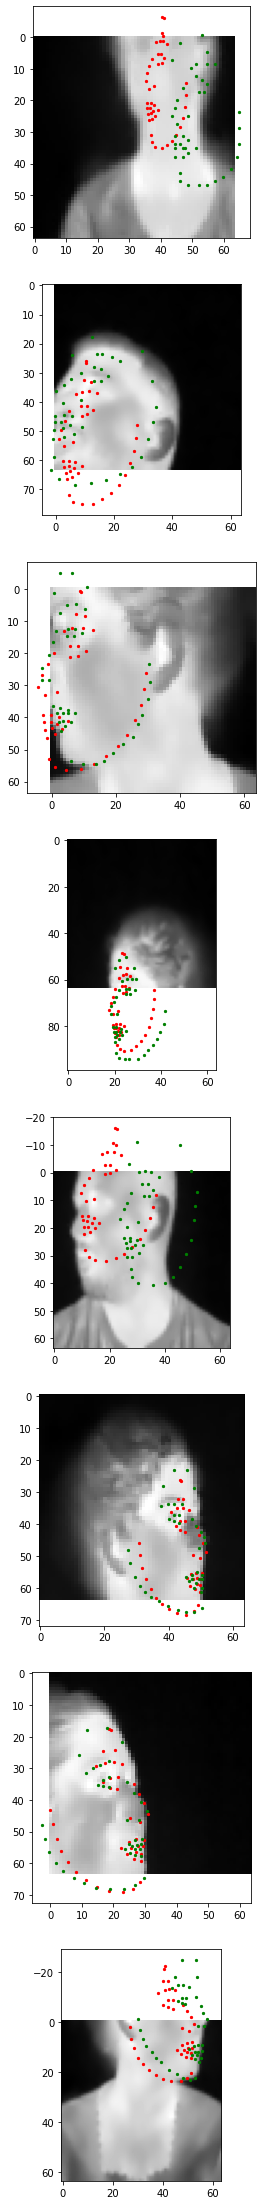

In [23]:
start_time = time.time()

with torch.no_grad():

    best_network = Network()
    best_network.cuda()
    best_network.load_state_dict(torch.load('.\\face_landmarks.pth')) 
    best_network.eval()
    
    item = next(iter(valid_loader))
    images = item['image'].to(device=device, dtype=torch.float)
    landmarks = item['landmarks'].to(device=device, dtype=torch.float)
    landmarks = (landmarks + 0.5) 

    predictions = (best_network(images).cpu() + 0.5)
    predictions = predictions.view(-1,43,2).cpu()
    print(predictions.shape)
    
    images = images.cpu()
    landmarks =landmarks.cpu()
    plt.figure(figsize=(10,40))
    
    for img_num in range(8):
        plt.subplot(8,1,img_num+1)
#         show_landmarks_val(images[img_num], predictions, landmarks)
        plt.imshow(images[img_num].cpu().numpy().transpose(1,2,0).squeeze(), cmap='gray')
        plt.scatter(predictions[img_num,:,0], predictions[img_num,:,1], c = 'r', s = 5)
        plt.scatter(landmarks[img_num,:,0], landmarks[img_num,:,1], c = 'g', s = 5)

print('Total number of test images: {}'.format(len(valid_dataset)))

end_time = time.time()
print("Elapsed Time : {}".format(end_time - start_time)) 